# Plague Classification of IP102 Dataset Using MobileNetV2

## Import Libraries 📦

In [1]:
# Import required libraries
import os
import glob

import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix

# Define root directory (where data and annotations are located)
root_dir = "/Users/isaacg/Desktop/Datasets/IP102"

## Check if GPU is Available 👨‍💻

In [2]:
# Check if TensorFlow is using GPU
print("Is TensorFlow using GPU? ", tf.config.list_physical_devices('GPU'))

Is TensorFlow using GPU?  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Prepare Data 🏷️

In [3]:
# Create dictionary that maps integer class index to string with name of class
file = os.path.join(root_dir, "classes.txt")   # txt file containing the name of the corresponding class

with open(file, "r") as file:
    lines = file.readlines()

classes = {}

# Get key and value for each class (line of txt file)
for line in lines:
    key, value = line.strip().split(" ", 1)
    classes[int(key.strip()) - 1] = value.strip()

In [4]:
# Create train, val and test directories (if have not been already created) by moving images from images folder to train, val and test folders
# directories to create (train, val and test)

if not os.path.isdir(os.path.join(root_dir, "train")):
    dirs = ["train", "val", "test"]

    for name in dirs:
        # inside this directory (train, val or test) create a directory for each insect class
        for class_name in classes.values():
            os.makedirs(os.path.join(root_dir, name, class_name))

    # txt files containig paths and classes of train, validation and test data
    filenames = ["train.txt", "val.txt", "test.txt"]
    
    # Move data from images directory to its corresponding directory
    for name, fname in zip(dirs, filenames):
        with open(os.path.join(root_dir, fname)) as infile:  # Read file with image paths and classes
            for line in infile:
                # Get image name and class
                img_name, img_class = line.strip().split(" ")
                os.rename(os.path.join(root_dir, "images", img_name), os.path.join(root_dir, name, classes[int(img_class)], img_name))
    

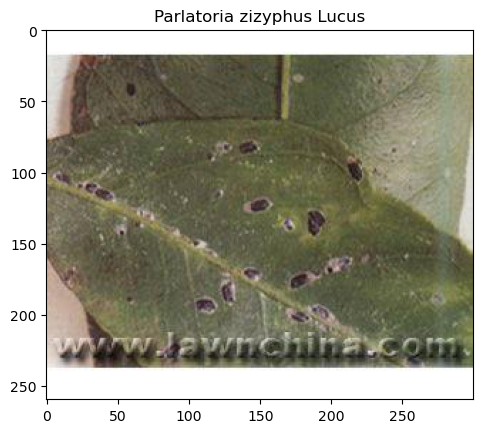

In [9]:
# Show a random image from IP102 dataset along its corresponging class

# paths of train images
train_paths = glob.glob(os.path.join(root_dir, "train/*/*"))
idx = np.random.randint(len(train_paths))
image = tf.keras.utils.load_img(train_paths[idx])
plt.imshow(image)
plt.title(train_paths[idx].split("/")[7])
plt.show()

## Load and Preprocess Data 🛠️

In [6]:
# Create Image Data Generators for loading data with data augmentation for training and 
# normalize pixel intensiry values to range [0, 1]
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
    #horizontal_flip=True,
    #vertical_flip=True)  # Rotations?

# For test and val only normalize pixel intensiry values to range [0, 1]
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size=64
# Resize images to 224x224
train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "train"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "val"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False)

Found 45095 images belonging to 102 classes.
Found 7508 images belonging to 102 classes.
Found 22619 images belonging to 102 classes.


In [7]:
# Create dictionary that maps integer class index to string with name of class according to
# Tensorflow assigned indices
classes_tf = inv_map = {idx: label for label, idx in test_gen.class_indices.items()}

## Create Model 👷‍♂️

In [8]:
# Download pretrained MobilenetV2 with ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet")

2024-09-20 11:10:20.642201: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-20 11:10:20.642252: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-20 11:10:20.642262: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-20 11:10:20.642362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-20 11:10:20.642400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Look at what this network does to an example batch of images
image_batch, label_batch = next(iter(train_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [11]:
# Freeze base model weigts
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [13]:
# Add new classification head

# Add Global Average Pooling to get a single 2048-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Add Dense layer for prediction
prediction_layer = tf.keras.layers.Dense(len(classes), activation="softmax")

In [14]:
# Build the model by chaining together base model and new classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # training is set to False so batch normalization works in inference mode
x = base_model(inputs)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainab

## Train Freezed Model (Only Train Modified Top) 🥶

In [17]:
# Compile the model

# Reduce learning rate by a factor of 0.1 every 25 epochs
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    name='ExponentialDecay'
)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

# Define callbacks

# For saving training history
csv_log = tf.keras.callbacks.CSVLogger("./Logs/history_MobileNetV2")

# Save best model every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./Models/mobilenetv2.keras_",
    monitor="val_accuracy", 
    save_best_only=True,
    mode="max")

# Stop if val accuracy does not increase after 10 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='max',
    start_from_epoch=10)

In [18]:
# Train freezed model for 50 epochs
initial_epochs = 40
history = model.fit(train_gen, epochs=initial_epochs, validation_data=val_gen, callbacks=[csv_log, checkpoint])

Epoch 1/40


2024-09-20 11:14:43.852521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-20 11:14:43.858801: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-09-20 11:14:44.553332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


705/705 [==============================] - ETA: 0s - loss: 2.6573 - accuracy: 0.3755

2024-09-20 11:16:59.289576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-20 11:16:59.490461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-20 11:17:23.083485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:17:24.245901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this m

INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 164s 228ms/step - loss: 2.6573 - accuracy: 0.3755 - val_loss: 2.1604 - val_accuracy: 0.4660
Epoch 2/40
705/705 [==============================] - ETA: 0s - loss: 2.0119 - accuracy: 0.4912

2024-09-20 11:19:59.635279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:20:01.173571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 157s 222ms/step - loss: 2.0119 - accuracy: 0.4912 - val_loss: 2.0000 - val_accuracy: 0.5009
Epoch 3/40
705/705 [==============================] - ETA: 0s - loss: 1.8278 - accuracy: 0.5276

2024-09-20 11:22:34.459246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:22:35.597547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 155s 219ms/step - loss: 1.8278 - accuracy: 0.5276 - val_loss: 1.9344 - val_accuracy: 0.5124
Epoch 4/40
705/705 [==============================] - ETA: 0s - loss: 1.7221 - accuracy: 0.5497

2024-09-20 11:25:10.506746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:25:11.616303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 156s 221ms/step - loss: 1.7221 - accuracy: 0.5497 - val_loss: 1.9225 - val_accuracy: 0.5181
Epoch 5/40
705/705 [==============================] - ETA: 0s - loss: 1.6461 - accuracy: 0.5656

2024-09-20 11:27:48.924107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:27:50.454311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 159s 225ms/step - loss: 1.6461 - accuracy: 0.5656 - val_loss: 1.9262 - val_accuracy: 0.5233
Epoch 6/40
705/705 [==============================] - ETA: 0s - loss: 1.5951 - accuracy: 0.5749

2024-09-20 11:30:25.781743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:30:26.944994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 156s 222ms/step - loss: 1.5951 - accuracy: 0.5749 - val_loss: 1.9036 - val_accuracy: 0.5270
Epoch 7/40
705/705 [==============================] - ETA: 0s - loss: 1.5527 - accuracy: 0.5817

2024-09-20 11:33:05.027943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:33:06.172086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 159s 226ms/step - loss: 1.5527 - accuracy: 0.5817 - val_loss: 1.9115 - val_accuracy: 0.5301
Epoch 8/40
705/705 [==============================] - ETA: 0s - loss: 1.5227 - accuracy: 0.5886

2024-09-20 11:35:43.116769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:35:44.306063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 158s 224ms/step - loss: 1.5227 - accuracy: 0.5886 - val_loss: 1.8991 - val_accuracy: 0.5341
Epoch 9/40
705/705 [==============================] - 148s 210ms/step - loss: 1.4970 - accuracy: 0.5932 - val_loss: 1.9150 - val_accuracy: 0.5321
Epoch 10/40
705/705 [==============================] - 152s 216ms/step - loss: 1.4756 - accuracy: 0.5983 - val_loss: 1.9296 - val_accuracy: 0.5302
Epoch 11/40
705/705 [==============================] - ETA: 0s - loss: 1.4610 - accuracy: 0.6015

2024-09-20 11:43:25.238801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:43:26.313372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 162s 229ms/step - loss: 1.4610 - accuracy: 0.6015 - val_loss: 1.9009 - val_accuracy: 0.5352
Epoch 12/40
705/705 [==============================] - ETA: 0s - loss: 1.4399 - accuracy: 0.6051

2024-09-20 11:46:01.133415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:46:02.386072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 156s 221ms/step - loss: 1.4399 - accuracy: 0.6051 - val_loss: 1.9268 - val_accuracy: 0.5390
Epoch 13/40
705/705 [==============================] - 152s 215ms/step - loss: 1.4266 - accuracy: 0.6065 - val_loss: 1.9180 - val_accuracy: 0.5366
Epoch 14/40
705/705 [==============================] - ETA: 0s - loss: 1.4214 - accuracy: 0.6066

2024-09-20 11:51:11.331036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 11:51:12.440429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 158s 224ms/step - loss: 1.4214 - accuracy: 0.6066 - val_loss: 1.9325 - val_accuracy: 0.5405
Epoch 15/40
705/705 [==============================] - 156s 221ms/step - loss: 1.4102 - accuracy: 0.6109 - val_loss: 1.9269 - val_accuracy: 0.5402
Epoch 16/40
705/705 [==============================] - 152s 216ms/step - loss: 1.3938 - accuracy: 0.6131 - val_loss: 1.9489 - val_accuracy: 0.5398
Epoch 17/40
705/705 [==============================] - 154s 219ms/step - loss: 1.3928 - accuracy: 0.6139 - val_loss: 1.9658 - val_accuracy: 0.5385
Epoch 18/40
705/705 [==============================] - 153s 218ms/step - loss: 1.3851 - accuracy: 0.6167 - val_loss: 1.9628 - val_accuracy: 0.5397
Epoch 19/40
705/705 [==============================] - ETA: 0s - loss: 1.3839 - accuracy: 0.6149

2024-09-20 12:04:08.984200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 12:04:10.334591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 162s 230ms/step - loss: 1.3839 - accuracy: 0.6149 - val_loss: 1.9596 - val_accuracy: 0.5408
Epoch 20/40
705/705 [==============================] - 150s 213ms/step - loss: 1.3719 - accuracy: 0.6170 - val_loss: 1.9740 - val_accuracy: 0.5408
Epoch 21/40
705/705 [==============================] - 152s 216ms/step - loss: 1.3627 - accuracy: 0.6194 - val_loss: 2.0045 - val_accuracy: 0.5374
Epoch 22/40
705/705 [==============================] - 156s 221ms/step - loss: 1.3658 - accuracy: 0.6216 - val_loss: 1.9857 - val_accuracy: 0.5378
Epoch 23/40
705/705 [==============================] - 152s 215ms/step - loss: 1.3589 - accuracy: 0.6224 - val_loss: 2.0079 - val_accuracy: 0.5346
Epoch 24/40
705/705 [==============================] - 154s 218ms/step - loss: 1.3645 - accuracy: 0.6201 - val_loss: 2.0289 - val_accuracy: 0.5354
Epoch 25/40
705/705 [==============================] - 156s 222ms/step - loss: 1.3595 - accuracy: 0.6176 - val_loss: 2.0240 - val_

2024-09-20 12:29:50.201617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 12:29:51.406047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 158s 224ms/step - loss: 1.3336 - accuracy: 0.6264 - val_loss: 2.0240 - val_accuracy: 0.5422
Epoch 30/40
705/705 [==============================] - ETA: 0s - loss: 1.3476 - accuracy: 0.6224

2024-09-20 12:32:29.719183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 12:32:30.904046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2.keras_/assets


705/705 [==============================] - 159s 226ms/step - loss: 1.3476 - accuracy: 0.6224 - val_loss: 2.0455 - val_accuracy: 0.5445
Epoch 31/40
705/705 [==============================] - 155s 220ms/step - loss: 1.3369 - accuracy: 0.6251 - val_loss: 2.0473 - val_accuracy: 0.5381
Epoch 32/40
705/705 [==============================] - 151s 214ms/step - loss: 1.3331 - accuracy: 0.6282 - val_loss: 2.0457 - val_accuracy: 0.5345
Epoch 33/40
705/705 [==============================] - 154s 219ms/step - loss: 1.3286 - accuracy: 0.6284 - val_loss: 2.0542 - val_accuracy: 0.5377
Epoch 34/40
705/705 [==============================] - 158s 224ms/step - loss: 1.3361 - accuracy: 0.6238 - val_loss: 2.0706 - val_accuracy: 0.5381
Epoch 35/40
705/705 [==============================] - 154s 218ms/step - loss: 1.3409 - accuracy: 0.6229 - val_loss: 2.0706 - val_accuracy: 0.5400
Epoch 36/40
705/705 [==============================] - 151s 215ms/step - loss: 1.3316 - accuracy: 0.6266 - val_loss: 2.0685 - val_

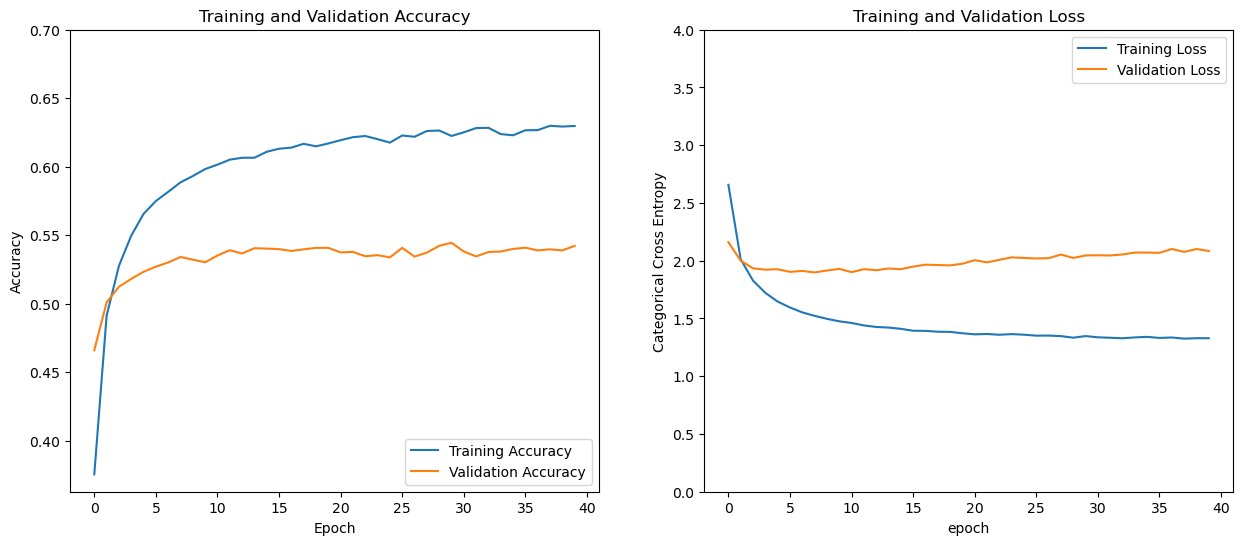

In [19]:
# Plot history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.7])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tune Model Unfreezing 4 Layers of Base Model 💪

In [20]:
# Look at how many layers the base model has 
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainab

In [22]:
# Unfreeze model for fine tuning
base_model.trainable = True

# Fine tune n layers of base model
fine_tune = 8

# Freeze all base model layers but last n layers
for layer in base_model.layers[:-fine_tune]:
  layer.trainable = False

In [23]:
# Reduce learning rate by a factor of 0.1 every 25 epochs
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1e-4,
    decay_steps=100000,
    decay_rate=0.96,
    name='ExponentialDecay'
)

# Recompile model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

# Define callbacks

# For saving training history
csv_log = tf.keras.callbacks.CSVLogger("./Logs/history_mobilenetv2_fine_")

# Save best model every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./Models/mobilenetv2_fine.keras_",
    monitor="val_accuracy", 
    save_best_only=True,
    mode="max")

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 861,222
Non-trainab

In [25]:
# Fine tune model

fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_gen, 
                         epochs=total_epochs, 
                         validation_data=val_gen,
                         initial_epoch=len(history.epoch),
                         callbacks=[csv_log, checkpoint])

Epoch 41/90


2024-09-20 13:00:57.524176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-20 13:00:58.386676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


705/705 [==============================] - ETA: 0s - loss: 1.8010 - accuracy: 0.5379

2024-09-20 13:03:15.648981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-20 13:03:15.837484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-20 13:03:39.408142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:03:40.522221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this m

INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 166s 231ms/step - loss: 1.8010 - accuracy: 0.5379 - val_loss: 2.6902 - val_accuracy: 0.5056
Epoch 42/90
705/705 [==============================] - ETA: 0s - loss: 1.4671 - accuracy: 0.5891

2024-09-20 13:06:19.017099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:06:20.233195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 160s 227ms/step - loss: 1.4671 - accuracy: 0.5891 - val_loss: 2.3765 - val_accuracy: 0.5161
Epoch 43/90
705/705 [==============================] - ETA: 0s - loss: 1.3712 - accuracy: 0.6127

2024-09-20 13:09:01.337173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:09:02.516664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 162s 229ms/step - loss: 1.3712 - accuracy: 0.6127 - val_loss: 2.1210 - val_accuracy: 0.5353
Epoch 44/90
705/705 [==============================] - ETA: 0s - loss: 1.3061 - accuracy: 0.6264

2024-09-20 13:11:42.750149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:11:43.868562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 161s 229ms/step - loss: 1.3061 - accuracy: 0.6264 - val_loss: 2.0222 - val_accuracy: 0.5422
Epoch 45/90
705/705 [==============================] - ETA: 0s - loss: 1.2523 - accuracy: 0.6404

2024-09-20 13:14:30.267801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:14:31.591078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 168s 238ms/step - loss: 1.2523 - accuracy: 0.6404 - val_loss: 1.9708 - val_accuracy: 0.5485
Epoch 46/90
705/705 [==============================] - ETA: 0s - loss: 1.2125 - accuracy: 0.6513

2024-09-20 13:17:12.344996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:17:13.493397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 162s 229ms/step - loss: 1.2125 - accuracy: 0.6513 - val_loss: 1.9321 - val_accuracy: 0.5521
Epoch 47/90
705/705 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.6619

2024-09-20 13:19:58.136767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:19:59.430970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 166s 235ms/step - loss: 1.1749 - accuracy: 0.6619 - val_loss: 1.9038 - val_accuracy: 0.5558
Epoch 48/90
705/705 [==============================] - ETA: 0s - loss: 1.1367 - accuracy: 0.6692

2024-09-20 13:22:47.296237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:22:48.511969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 169s 240ms/step - loss: 1.1367 - accuracy: 0.6692 - val_loss: 1.8869 - val_accuracy: 0.5579
Epoch 49/90
705/705 [==============================] - ETA: 0s - loss: 1.1105 - accuracy: 0.6764

2024-09-20 13:25:46.881558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:25:48.064667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 179s 255ms/step - loss: 1.1105 - accuracy: 0.6764 - val_loss: 1.8756 - val_accuracy: 0.5585
Epoch 50/90
705/705 [==============================] - ETA: 0s - loss: 1.0848 - accuracy: 0.6832

2024-09-20 13:28:40.553646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:28:41.729524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 174s 246ms/step - loss: 1.0848 - accuracy: 0.6832 - val_loss: 1.8650 - val_accuracy: 0.5630
Epoch 51/90
705/705 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.6936

2024-09-20 13:31:32.033058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:31:33.239111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 171s 243ms/step - loss: 1.0528 - accuracy: 0.6936 - val_loss: 1.8582 - val_accuracy: 0.5663
Epoch 52/90
705/705 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.6989

2024-09-20 13:34:26.707426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:34:27.885806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 175s 248ms/step - loss: 1.0294 - accuracy: 0.6989 - val_loss: 1.8467 - val_accuracy: 0.5673
Epoch 53/90
705/705 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.7051

2024-09-20 13:37:24.777166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:37:25.906512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 178s 252ms/step - loss: 1.0111 - accuracy: 0.7051 - val_loss: 1.8398 - val_accuracy: 0.5702
Epoch 54/90
705/705 [==============================] - ETA: 0s - loss: 0.9868 - accuracy: 0.7106

2024-09-20 13:40:13.492152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:40:14.830680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 169s 240ms/step - loss: 0.9868 - accuracy: 0.7106 - val_loss: 1.8360 - val_accuracy: 0.5725
Epoch 55/90
705/705 [==============================] - ETA: 0s - loss: 0.9694 - accuracy: 0.7150

2024-09-20 13:42:57.477888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:42:58.656165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 164s 232ms/step - loss: 0.9694 - accuracy: 0.7150 - val_loss: 1.8322 - val_accuracy: 0.5742
Epoch 56/90
705/705 [==============================] - ETA: 0s - loss: 0.9485 - accuracy: 0.7202

2024-09-20 13:45:45.294650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:45:46.599720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 168s 238ms/step - loss: 0.9485 - accuracy: 0.7202 - val_loss: 1.8322 - val_accuracy: 0.5747
Epoch 57/90
705/705 [==============================] - ETA: 0s - loss: 0.9325 - accuracy: 0.7235

2024-09-20 13:48:35.900277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:48:37.091891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 170s 242ms/step - loss: 0.9325 - accuracy: 0.7235 - val_loss: 1.8267 - val_accuracy: 0.5782
Epoch 58/90
705/705 [==============================] - ETA: 0s - loss: 0.9118 - accuracy: 0.7313

2024-09-20 13:51:25.223432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:51:26.395335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 169s 240ms/step - loss: 0.9118 - accuracy: 0.7313 - val_loss: 1.8228 - val_accuracy: 0.5796
Epoch 59/90
705/705 [==============================] - 164s 232ms/step - loss: 0.8921 - accuracy: 0.7359 - val_loss: 1.8238 - val_accuracy: 0.5786
Epoch 60/90
705/705 [==============================] - ETA: 0s - loss: 0.8829 - accuracy: 0.7408

2024-09-20 13:56:59.112036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:57:00.266729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 170s 241ms/step - loss: 0.8829 - accuracy: 0.7408 - val_loss: 1.8211 - val_accuracy: 0.5815
Epoch 61/90
705/705 [==============================] - ETA: 0s - loss: 0.8651 - accuracy: 0.7445

2024-09-20 13:59:50.162453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 13:59:51.312335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 171s 243ms/step - loss: 0.8651 - accuracy: 0.7445 - val_loss: 1.8163 - val_accuracy: 0.5834
Epoch 62/90
705/705 [==============================] - 163s 231ms/step - loss: 0.8505 - accuracy: 0.7480 - val_loss: 1.8119 - val_accuracy: 0.5823
Epoch 63/90
705/705 [==============================] - ETA: 0s - loss: 0.8392 - accuracy: 0.7503

2024-09-20 14:05:17.669552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:05:18.821923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 165s 234ms/step - loss: 0.8392 - accuracy: 0.7503 - val_loss: 1.8147 - val_accuracy: 0.5855
Epoch 64/90
705/705 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.7550

2024-09-20 14:08:09.016662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:08:10.205474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 171s 243ms/step - loss: 0.8223 - accuracy: 0.7550 - val_loss: 1.8102 - val_accuracy: 0.5863
Epoch 65/90
705/705 [==============================] - 163s 231ms/step - loss: 0.8027 - accuracy: 0.7597 - val_loss: 1.8121 - val_accuracy: 0.5854
Epoch 66/90
705/705 [==============================] - 159s 226ms/step - loss: 0.7984 - accuracy: 0.7598 - val_loss: 1.8117 - val_accuracy: 0.5842
Epoch 67/90
705/705 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.7665

2024-09-20 14:16:16.156203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:16:17.452496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 165s 234ms/step - loss: 0.7830 - accuracy: 0.7665 - val_loss: 1.8113 - val_accuracy: 0.5864
Epoch 68/90
705/705 [==============================] - ETA: 0s - loss: 0.7714 - accuracy: 0.7694

2024-09-20 14:19:03.786305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:19:04.966729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 168s 238ms/step - loss: 0.7714 - accuracy: 0.7694 - val_loss: 1.8072 - val_accuracy: 0.5892
Epoch 69/90
705/705 [==============================] - 163s 230ms/step - loss: 0.7633 - accuracy: 0.7707 - val_loss: 1.8004 - val_accuracy: 0.5890
Epoch 70/90
705/705 [==============================] - 161s 228ms/step - loss: 0.7421 - accuracy: 0.7784 - val_loss: 1.7986 - val_accuracy: 0.5888
Epoch 71/90
705/705 [==============================] - 162s 229ms/step - loss: 0.7324 - accuracy: 0.7810 - val_loss: 1.8018 - val_accuracy: 0.5892
Epoch 72/90
705/705 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.7849

2024-09-20 14:29:57.308961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:29:58.440817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 169s 239ms/step - loss: 0.7230 - accuracy: 0.7849 - val_loss: 1.8066 - val_accuracy: 0.5903
Epoch 73/90
705/705 [==============================] - 161s 228ms/step - loss: 0.7134 - accuracy: 0.7876 - val_loss: 1.8084 - val_accuracy: 0.5894
Epoch 74/90
705/705 [==============================] - 159s 226ms/step - loss: 0.6992 - accuracy: 0.7911 - val_loss: 1.8059 - val_accuracy: 0.5896
Epoch 75/90
705/705 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.7932

2024-09-20 14:38:03.672917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:38:04.784725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 166s 235ms/step - loss: 0.6900 - accuracy: 0.7932 - val_loss: 1.8037 - val_accuracy: 0.5914
Epoch 76/90
705/705 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7986

2024-09-20 14:40:49.765525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:40:51.145693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 167s 236ms/step - loss: 0.6790 - accuracy: 0.7986 - val_loss: 1.8012 - val_accuracy: 0.5923
Epoch 77/90
705/705 [==============================] - 156s 222ms/step - loss: 0.6699 - accuracy: 0.7991 - val_loss: 1.8081 - val_accuracy: 0.5916
Epoch 78/90
705/705 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.8016

2024-09-20 14:46:05.830072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:46:06.938096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 159s 226ms/step - loss: 0.6609 - accuracy: 0.8016 - val_loss: 1.8117 - val_accuracy: 0.5930
Epoch 79/90
705/705 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.8068

2024-09-20 14:48:45.674245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:48:46.936218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 160s 227ms/step - loss: 0.6505 - accuracy: 0.8068 - val_loss: 1.8077 - val_accuracy: 0.5952
Epoch 80/90
705/705 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.8069

2024-09-20 14:51:27.808483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:51:28.910184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 162s 230ms/step - loss: 0.6433 - accuracy: 0.8069 - val_loss: 1.8017 - val_accuracy: 0.5958
Epoch 81/90
705/705 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.8117

2024-09-20 14:54:08.794380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 14:54:09.896877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 161s 228ms/step - loss: 0.6316 - accuracy: 0.8117 - val_loss: 1.8057 - val_accuracy: 0.5959
Epoch 82/90
705/705 [==============================] - 154s 218ms/step - loss: 0.6208 - accuracy: 0.8144 - val_loss: 1.8111 - val_accuracy: 0.5938
Epoch 83/90
705/705 [==============================] - 154s 218ms/step - loss: 0.6158 - accuracy: 0.8153 - val_loss: 1.8061 - val_accuracy: 0.5932
Epoch 84/90
705/705 [==============================] - 156s 221ms/step - loss: 0.6146 - accuracy: 0.8166 - val_loss: 1.8063 - val_accuracy: 0.5932
Epoch 85/90
705/705 [==============================] - 156s 221ms/step - loss: 0.6044 - accuracy: 0.8182 - val_loss: 1.8094 - val_accuracy: 0.5955
Epoch 86/90
705/705 [==============================] - 156s 220ms/step - loss: 0.5871 - accuracy: 0.8244 - val_loss: 1.8044 - val_accuracy: 0.5951
Epoch 87/90
705/705 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.8234

2024-09-20 15:09:46.966941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 15:09:48.079591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 163s 232ms/step - loss: 0.5889 - accuracy: 0.8234 - val_loss: 1.8085 - val_accuracy: 0.5967
Epoch 88/90
705/705 [==============================] - 155s 220ms/step - loss: 0.5759 - accuracy: 0.8295 - val_loss: 1.8125 - val_accuracy: 0.5960
Epoch 89/90
705/705 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.8308

2024-09-20 15:15:04.504518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-09-20 15:15:05.963082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


INFO:tensorflow:Assets written to: ./Models/mobilenetv2_fine.keras_/assets


705/705 [==============================] - 162s 230ms/step - loss: 0.5661 - accuracy: 0.8308 - val_loss: 1.8076 - val_accuracy: 0.5998
Epoch 90/90
705/705 [==============================] - 154s 219ms/step - loss: 0.5599 - accuracy: 0.8330 - val_loss: 1.8119 - val_accuracy: 0.5987


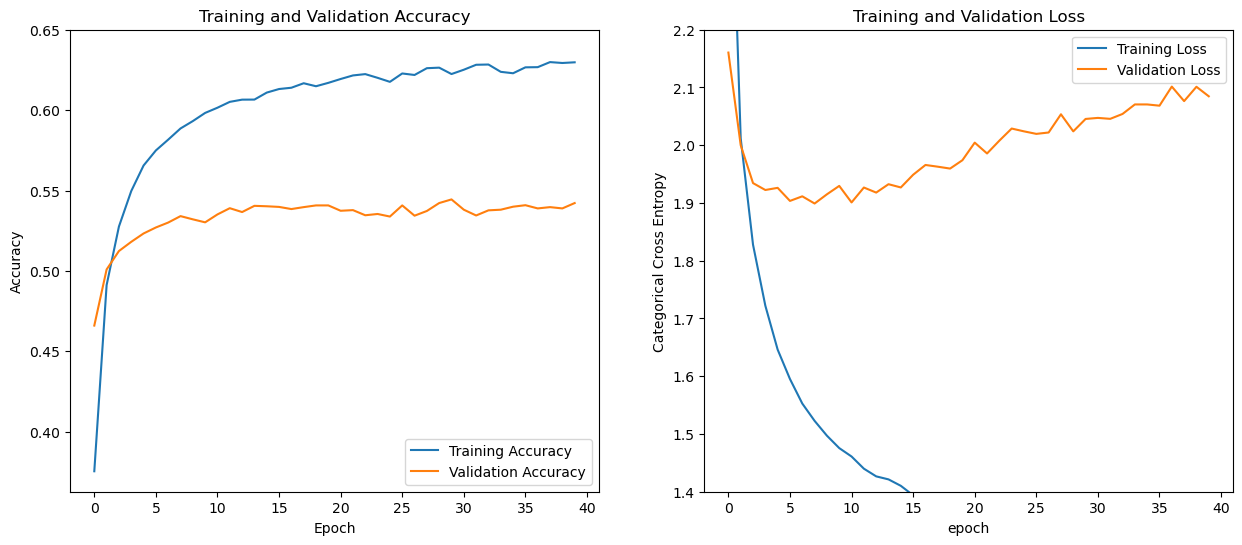

In [26]:
# Plot history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.65])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([1.4,2.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Retrain with Higher Learning Rate 🏋️

In [ ]:
# Train the model for 25 epochs with higer lr
# Reduce learning rate by a factor of 0.1 every 25 epochs
lr = 1e-5

# Recompile model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

# Define callbacks

# For saving training history
csv_log = tf.keras.callbacks.CSVLogger("./Logs/history_mobilenetv2_fine2_")

# Save best model every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./Models/mobilenetv2_fine2.keras_",
    monitor="val_accuracy", 
    save_best_only=True,
    mode="max")

In [ ]:
fine_tune2_epochs = 25
total_epochs = initial_epochs + fine_tune_epochs + fine_tune2_epochs

history_fine = model.fit(train_gen, 
                         epochs=total_epochs, 
                         validation_data=val_gen,
                         initial_epoch=initial_epochs + fine_tune_epochs,
                         callbacks=[csv_log, checkpoint])

In [ ]:
# Plot history
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([.8,1.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Plot Full Training History 📈

In [27]:
# Concatenate history of each training to plot all history
hist1 = pd.read_csv("Logs/history_MobileNetv2")
hist2 = pd.read_csv("Logs/history_mobilenetv2_fine")
hist3 = pd.read_csv("Logs/history_mobilenetv2_fine2")

history_all = pd.concat([hist1, hist2, hist3])
history_all["epoch"] += 1
epoch0 = pd.DataFrame({'epoch':0, 'accuracy':0, 'loss':10,
                        'val_accuracy':0, 'val_loss':10},
                                                            index =[0])
history_all = pd.concat([epoch0, history_all])  # Add epoch 0 to dataframe

# Extract acc, val_acc, loss and val_loss
acc = history_all['accuracy']
val_acc = history_all['val_accuracy']

loss = history_all['loss']
val_loss = history_all['val_loss']

epochs = history_all["epoch"]

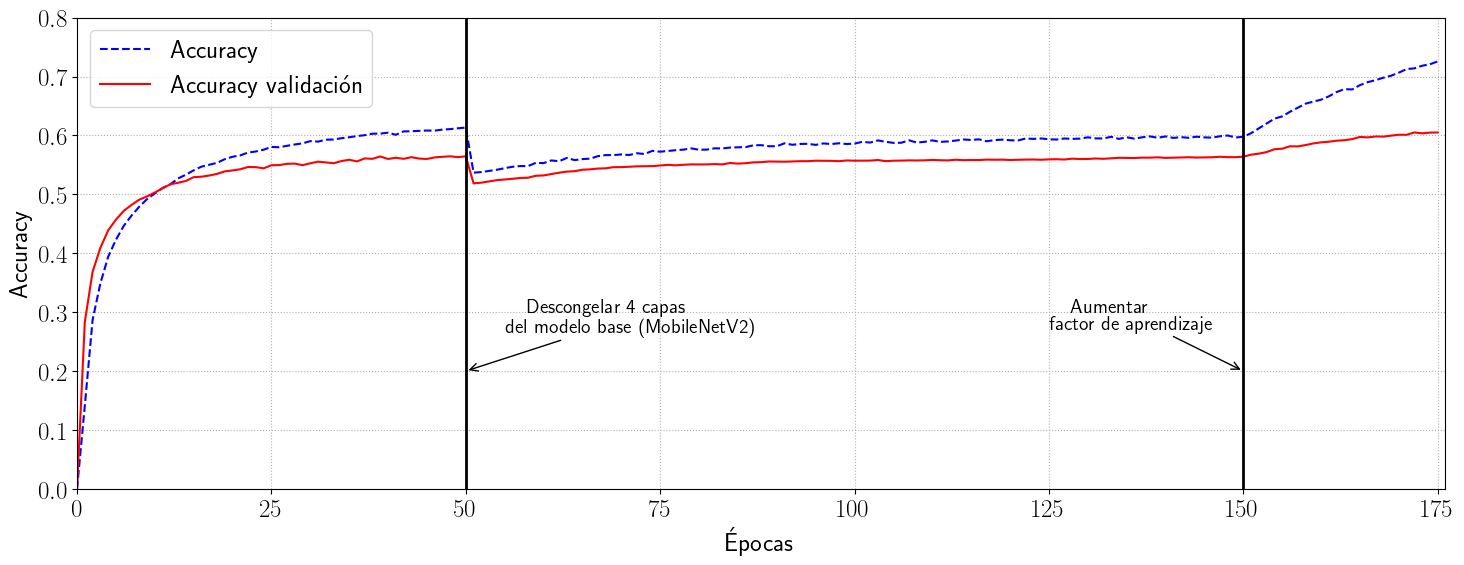

In [38]:
# Plot accuracy
plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True # TeX rendering

#with plt.style.context("dark_background"):
    
plt.figure(figsize=(15, 6))
plt.plot(epochs, acc, "b--", label="Accuracy")
plt.plot(epochs, val_acc, "r-", label="Accuracy validación")
plt.plot([50, 50], [-1, 0.8], "k", linewidth=2)
plt.plot([150, 150], [-1, 0.8], "k", linewidth=2)
plt.xlabel(r"Épocas")
plt.ylabel(r"Accuracy")
plt.ylim([0, 0.8])
plt.xlim([0, 176])
plt.annotate(r"Descongelar 4 capas\\ del modelo base (MobileNetV2)", (50, 0.2), xytext=(55, 0.3), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.annotate(r"Aumentar\\ factor de aprendizaje", (150, 0.2), xytext=(125, 0.3), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175])
plt.grid(linestyle="dotted")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/acc_plot.svg", dpi=400)

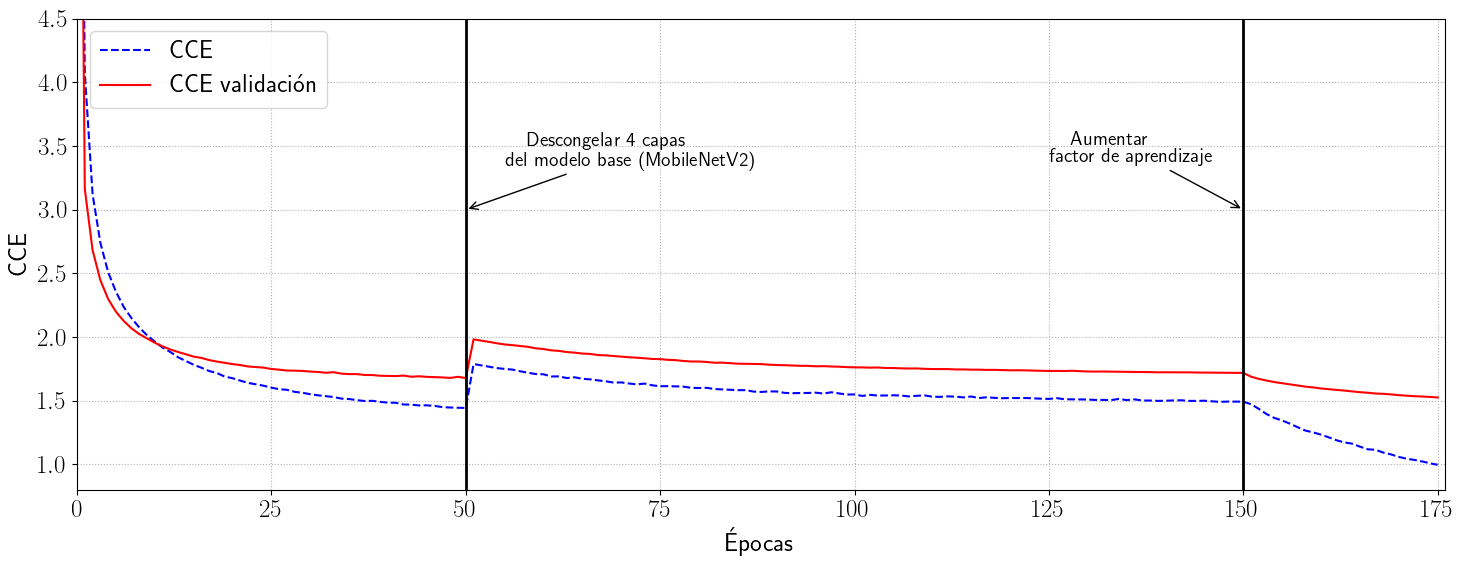

In [37]:
# Plot loss
plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True # TeX rendering
    
plt.figure(figsize=(15, 6))
plt.plot(epochs, loss, "b--", label="CCE")
plt.plot(epochs, val_loss, "r-", label="CCE validación")
plt.plot([50, 50], [0, 4.6], "k", linewidth=2)
plt.plot([150, 150], [0, 4.6], "k", linewidth=2)
plt.xlabel(r"Épocas")
plt.ylabel(r"CCE")
plt.ylim([0.8, 4.5])
plt.xlim([0, 176])
plt.annotate(r"Descongelar 4 capas\\ del modelo base (MobileNetV2)", (50, 3), xytext=(55, 3.5), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.annotate(r"Aumentar\\ factor de aprendizaje", (150, 3), xytext=(125, 3.5), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175])
plt.grid(linestyle="dotted")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/loss_plot.svg", dpi=400)

## Evaluate Model 🧐

In [12]:
model = tf.keras.models.load_model("./Models/mobilenetv2_fine2.keras", compile=False)

In [27]:
# Make predictions over test set
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)  # Apply argmax to get class of each image

2024-09-20 15:48:11.907837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-20 15:48:12.127919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22619/22619 [==============================] - 252s 11ms/step


In [28]:
# Create classification report
print(classification_report(test_gen.classes, y_pred, target_names=test_gen.class_indices.keys()))

                                 precision    recall  f1-score   support

                  Adristyrannus       0.64      0.51      0.57        94
       Aleurocanthus spiniferus       0.82      0.83      0.83       208
                    Ampelophaga       0.67      0.62      0.64       230
    Aphis citricola Vander Goot       0.60      0.52      0.56       106
               Apolygus lucorum       0.36      0.23      0.28       115
           Bactrocera tsuneonis       0.59      0.25      0.36        51
                Beet spot flies       0.56      0.49      0.52        90
   Brevipoalpus lewisi McGregor       0.84      0.67      0.74        24
             Ceroplastes rubens       0.79      0.71      0.74        78
           Chlumetia transversa       0.58      0.46      0.51        92
          Chrysomphalus aonidum       0.70      0.56      0.62        68
              Cicadella viridis       0.70      0.68      0.69       384
                   Cicadellidae       0.73      0.

In [29]:
# Generate confussion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

In [30]:
# Calculate sensitivity for each class from confussion matrix
TP = np.diag(cm) # True positive
FN = np.sum(cm, axis=1) - TP # False negative
S = TP / (TP + FN)  # Sensitivity

In [31]:
# Calculate Geometric Mean using sensitivity
GM = np.prod(S ** (1/102))
print(f"Geometric mean for model is: {GM}")

Geometric mean for model is: 0.4565228874470655


## Visualize Grad-CAM 📸

In [38]:
# Unwrap model to use with gradcam
def unwrap_model(model):
    mobile = model.get_layer('mobilenetv2_1.00_224')
    inp = mobile.input
    out = model.get_layer('global_average_pooling2d')(mobile.output)
    out = model.get_layer('dropout')(out)
    out = model.get_layer('dense')(out)
    return tf.keras.Model(inp, out) 

model_unwrapped = unwrap_model(model)
model_unwrapped.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [39]:
last_conv_layer = "Conv_1"

In [40]:
# Function to generate gradcam heatmap
# from: https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=None):
    # Input is (224, 244, 3)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)
    
    # Create model that maps input image to activations of last conv layer and output preds
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [41]:
# Create sumperimposed image
# From: https://keras.io/examples/vision/grad_cam/
def display_gradcam(img, heatmap, alpha=0.9):

    # Rescale heatmap and img to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

In [53]:
# Get 8 images and labels from test set to visualize grad cam
test_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True)
test = iter(test_gen)

imgs = []
labels = [] 
for i in range(8):
    img, label = next(test)
    imgs.append(img[0])
    labels.append(np.argmax(label))

Found 22619 images belonging to 102 classes.


In [54]:
# Get gradcams for 8 images
gradcams = []
for img in imgs:
    heatmap = make_gradcam_heatmap(img, model_unwrapped, last_conv_layer)
    gradcams.append(display_gradcam(img, heatmap, alpha=0.7))

In [55]:
# Get model prediction for each image
imgs = np.array(imgs)  # Convert to batch (8, 224, 224, 3)
preds = model.predict(imgs)
preds = np.argmax(preds, axis=1)  # Get class index

1/1 [==============================] - 0s 27ms/step


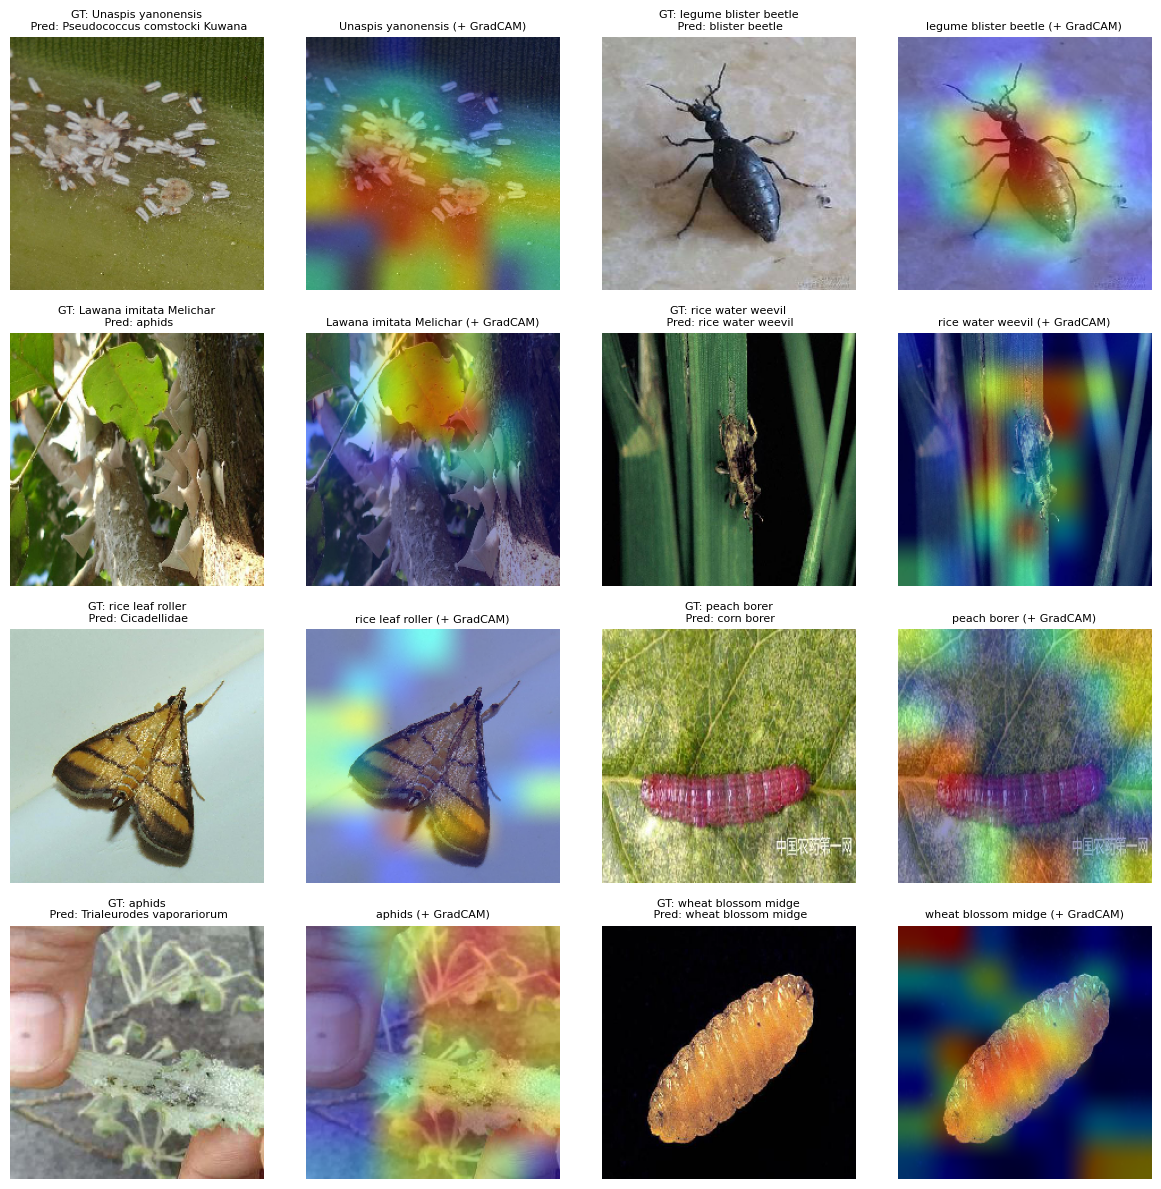

In [56]:
# Generate image with gradcams
# Based on: https://github.com/thushv89/manning_tf2_in_action/blob/master/Ch07-Improving-CNNs-and-Explaining/7.3.Interpreting_CNNs_GradCAM.ipynb

fig, axes = plt.subplots(4, 4, figsize=(12,  12))

for i, cam in enumerate(gradcams):
    img = imgs[i]
    offset = 2 * (i%2)
    
    # Plot eeach image
    axes[i//2][offset].imshow(img)
    
    # Plot gradcam
    axes[i//2][offset+1].imshow(cam)
    
    # Set label and turn off axis
    axes[i//2][offset].set_title(f"GT: {classes_tf[labels[i]]}\n Pred: {classes_tf[preds[i]]}", fontsize=8)
    axes[i//2][offset+1].set_title(classes_tf[labels[i]] + " (+ GradCAM)", fontsize=8)
    axes[i//2][offset].axis("off")
    axes[i//2][offset+1].axis("off")
    
plt.savefig("Figures/gradcam.png", dpi=400)
plt.tight_layout()

## Inference Time 🤠

In [59]:
test_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True)
test_data = iter(test_gen)

Found 22619 images belonging to 102 classes.


1/1 [==============================] - 0s 28ms/step


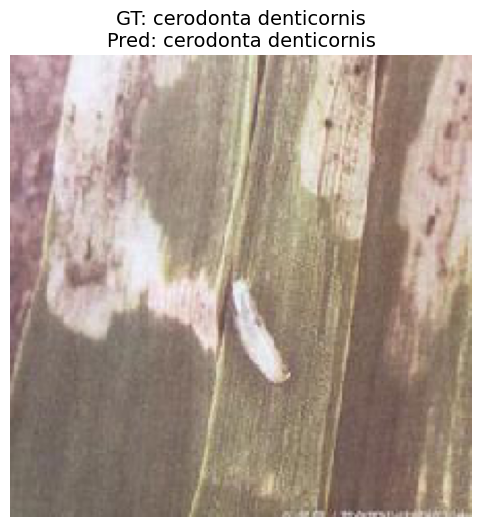

In [60]:
# Look at inferences over test set
img, label = next(test_data)  # Get image and label from image generator
label = np.argmax(label)  # Get class index

# Get pred from model
pred = model.predict(img)
pred = np.argmax(pred)  # Get class idx

plt.figure(figsize=(6, 6))
plt.imshow(img[0])
plt.title(f"GT: {classes_tf[label]}\nPred: {classes_tf[pred]}", fontsize=14)
plt.axis("off")
plt.show()